In [ ]:
# ===================================================================
# IMPROVED PIPELINE V2: BiLSTM -> TabNet -> Ridge
# TARGET: Minimize RMSE and SMAPE for IHSG Closing Price Prediction
# ===================================================================
# - UPDATED: Feature engineering now matches the LightGBM version to ensure 3k-4k data rows.
# - UPDATED: Plotting logic is gap-free and includes standalone LSTM predictions.
# - FIXED: Rebuilt LSTM model with Functional API to correctly implement Attention and Flatten layers.
# - FIXED: Corrected smape_loss function for TF2 compatibility.
# - ADDED: Print statements for data counts and raw IHSG data table display.

# -------------------
# 1. Imports & Config
# -------------------
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from pytorch_tabnet.metrics import Metric # Import Metric class
import shap

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# ---------------------
# 2. Data Preparation
# ---------------------
print("--- Loading and Preparing Data ---")
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

variables = {
    "IHSG": "^JKSE", "S&P 500": "^GSPC", "Nasdaq": "^IXIC", "VIX": "^VIX",
    "Hang Seng Index": "^HSI", "Crude Oil (WTI)": "CL=F", "Gold": "GC=F",
    "USD/IDR": "IDR=X", "DAX": "^GDAXI", "Crude Oil (Brent)": "BZ=F",
    "EUR/USD": "EURUSD=X", "Copper": "HG=F", "Silver": "SI=F"
}
data_ohlc = yf.download(list(variables.values()), start=start_date, end=end_date, auto_adjust=False)

# --- RESEARCH STEP 1: Isolate, Show, and Export Raw IHSG Data ---
ihsg_raw_df = data_ohlc.loc[:, (slice(None), '^JKSE')]
ihsg_raw_df.columns = ihsg_raw_df.columns.droplevel(1)
ihsg_raw_df.dropna(inplace=True)

print("\n--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---")
print(ihsg_raw_df.head().reset_index().to_string())
print(f"\n{len(ihsg_raw_df)} rows x {len(ihsg_raw_df.columns)} columns")
ihsg_raw_df.to_csv('raw_ihsg_data_tabnet.csv')
print("Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'")

# --- Continue with the full dataset for feature engineering ---
data = data_ohlc['Close'].copy()
volume = data_ohlc['Volume'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
volume.rename(columns={v: f"{k}_Volume" for k, v in variables.items()}, inplace=True)


try:
    fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
    data = data.join(fed_rate)
    data.rename(columns={'FEDFUNDS': 'Federal Funds Rate (Effective)'}, inplace=True)
    variables["Federal Funds Rate (Effective)"] = "Federal Funds Rate (Effective)"
except Exception as e:
    print(f"Could not fetch FEDFUNDS data. Error: {e}")

data = data.join(volume)
data.dropna(axis=1, how='all', inplace=True)
data = data.ffill().bfill()

# --- Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# --- TECHNICAL INDICATORS (Manual Calculation) ---
exp1 = data['IHSG'].ewm(span=12, adjust=False).mean()
exp2 = data['IHSG'].ewm(span=26, adjust=False).mean()
data['MACD_12_26_9'] = exp1 - exp2
data['MACDs_12_26_9'] = data['MACD_12_26_9'].ewm(span=9, adjust=False).mean()
data['MACDh_12_26_9'] = data['MACD_12_26_9'] - data['MACDs_12_26_9']
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['BBM_20_2.0'] = data['IHSG'].rolling(window=20).mean()
std_dev = data['IHSG'].rolling(window=20).std()
data['BBU_20_2.0'] = data['BBM_20_2.0'] + (std_dev * 2)
data['BBL_20_2.0'] = data['BBM_20_2.0'] - (std_dev * 2)

# --- ENGINEERED FEATURES & TIME-BASED FEATURES ---
for col in variables.keys():
    if col != 'IHSG' and col in data.columns:
        for lag in [1, 2, 3, 5, 10, 21]:
            data[f'{col}_pct_change_{lag}d'] = data[col].pct_change(lag)

data['Gold_vs_SP500'] = data['Gold'] / data['S&P 500']
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['DayOfYear'] = data.index.dayofyear
data.dropna(inplace=True)

# --- RESEARCH STEP 2: Show and Export Featured Data ---
print("\n--- Featured Data Snapshot ---")
print(data.head())
data.to_csv('featured_data_tabnet.csv')
print("Featured data exported to 'featured_data_tabnet.csv'")

# ---------------------------
# 3. Data for Price Prediction
# ---------------------------
data['Target'] = data['IHSG'].shift(-1)
data.dropna(inplace=True)

features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']

categorical_cols = ['DayOfWeek', 'Month', 'WeekOfYear', 'DayOfYear']
categorical_idxs = [features.index(col) for col in categorical_cols]
categorical_dims = [len(X[col].unique()) for col in categorical_cols]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTotal data rows after feature engineering and cleaning: {len(X)}")
print(f"Total training data rows: {len(X_train)}")
print(f"Total test data rows: {len(X_test)}")

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# --- RESEARCH STEP 3: Show Scaled Data ---
print("\n--- Scaled Training Data Snapshot (First 5 Rows) ---")
print(X_train_scaled[:5])

/home/rangga/metopen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-12 15:30:07.924752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752309008.081208    7044 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752309008.125685    7044 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752309008.441822    7044 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0

--- Loading and Preparing Data ---


[*********************100%***********************]  13 of 13 completed



--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---
Price       Date    Adj Close        Close         High          Low         Open      Volume
0     2010-01-04  2575.312988  2575.413086  2576.055908  2532.895996  2533.947998  18339300.0
1     2010-01-05  2605.175537  2605.277100  2606.069092  2575.616943  2575.616943  57043800.0
2     2010-01-06  2603.195557  2603.297119  2622.115967  2587.709961  2605.480957  51569100.0
3     2010-01-07  2586.794189  2586.895020  2611.603027  2570.272949  2603.500977  45510800.0
4     2010-01-08  2614.268311  2614.370117  2614.535889  2583.846924  2586.792969  73723500.0

3767 rows x 6 columns
Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'

--- Performing Advanced Feature Engineering ---

--- Featured Data Snapshot ---
            Crude Oil (Brent)  Crude Oil (WTI)   EUR/USD         Gold  Copper  \
Date                                                                            
2010-02-01          73.110001        74.430000  1.392699 

In [ ]:
# -----------------------------------
# 4. BiLSTM Model with Attention (tuned)
# -----------------------------------
print("\n--- Training LSTM Model with Attention ---")
TIME_STEPS = 60

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

def smape_loss(y_true, y_pred):
    epsilon = 0.1
    numer = tf.abs(y_pred - y_true)
    denom = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    return 100 * tf.reduce_mean(numer / denom)

def objective_lstm(trial):
    # --- UPDATED: Number of layers is now a hyperparameter ---
    n_layers = trial.suggest_categorical('n_layers', [1, 2])
    
    inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    
    # First BiLSTM layer is always present
    x = LSTM(trial.suggest_int('units1', 32, 128, step=16), return_sequences=True)(inputs)
    x = Dropout(trial.suggest_float('dropout1', 0.1, 0.4))(x)
    
    # Conditionally add the second BiLSTM layer
    if n_layers == 2:
        x = LSTM(trial.suggest_int('units2', 16, 64, step=16), return_sequences=True)(x)
        x = Dropout(trial.suggest_float('dropout2', 0.1, 0.4))(x)
    
    # Attention Layer always receives a sequence
    attention_out = Attention()([x, x])
    flatten_out = Flatten()(attention_out)
    
    dense_out = flatten_out
    if trial.suggest_categorical('dense_layer', [0, 1]):
        dense_out = Dense(trial.suggest_int('dense_units', 16, 64, step=16), activation='relu')(dense_out)
        
    outputs = Dense(1)(dense_out)
    model = Model(inputs=inputs, outputs=outputs)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    model.compile(optimizer=Adam(lr), loss=smape_loss)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    hist = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=2)
    return min(hist.history['val_loss'])

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=15)
best_lstm_params = study_lstm.best_params
print(best_lstm_params)


--- Training Bidirectional LSTM Model with Attention ---


2025-07-12 15:30:15.527562: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
356/356 - 34s - 95ms/step - loss: 8.4160 - val_loss: 4.0222
Epoch 2/50
356/356 - 26s - 74ms/step - loss: 4.7429 - val_loss: 8.9206
Epoch 3/50
356/356 - 25s - 70ms/step - loss: 4.0990 - val_loss: 5.9327
Epoch 4/50
356/356 - 27s - 77ms/step - loss: 3.7966 - val_loss: 9.3341
Epoch 5/50
356/356 - 26s - 72ms/step - loss: 3.5753 - val_loss: 6.5607
Epoch 6/50
356/356 - 26s - 74ms/step - loss: 3.4400 - val_loss: 7.3345
Epoch 7/50
356/356 - 24s - 68ms/step - loss: 3.0861 - val_loss: 7.2896
Epoch 8/50
356/356 - 27s - 75ms/step - loss: 2.9451 - val_loss: 5.3719
Epoch 9/50
356/356 - 29s - 82ms/step - loss: 2.8301 - val_loss: 5.3627
Epoch 10/50
356/356 - 29s - 81ms/step - loss: 2.8075 - val_loss: 8.6452
Epoch 11/50
356/356 - 32s - 91ms/step - loss: 2.7980 - val_loss: 6.4402
Epoch 1/50
89/89 - 12s - 140ms/step - loss: 10.3820 - val_loss: 2.6562
Epoch 2/50
89/89 - 6s - 64ms/step - loss: 3.8735 - val_loss: 5.2391
Epoch 3/50
89/89 - 6s - 62ms/step - loss: 3.4424 - val_loss: 9.2233
Epoch 4/50

In [ ]:
# --- UPDATED: Build the final model based on the best number of layers found ---
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(best_lstm_params['units1'], return_sequences=True)(inputs)
x = Dropout(best_lstm_params['dropout1'])(x)

if best_lstm_params['n_layers'] == 2:
    x = LSTM(best_lstm_params['units2'], return_sequences=True)(x)
    x = Dropout(best_lstm_params['dropout2'])(x)

attention_out = Attention()([x, x])
flatten_out = Flatten()(attention_out)
dense_out = flatten_out
if best_lstm_params['dense_layer']:
    dense_out = Dense(best_lstm_params['dense_units'], activation='relu')(dense_out)
outputs = Dense(1)(dense_out)
final_lstm = Model(inputs=inputs, outputs=outputs)

final_lstm.compile(optimizer=Adam(best_lstm_params['lr']), loss=smape_loss)
final_lstm.fit(X_train_seq, y_train_seq, epochs=150, batch_size=best_lstm_params['batch_size'], validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)], verbose=2)

lstm_pred_train_scaled = final_lstm.predict(X_train_seq)
lstm_pred_test_scaled = final_lstm.predict(X_test_seq)

Epoch 1/150
178/178 - 12s - 66ms/step - loss: 7.7129 - val_loss: 2.9695
Epoch 2/150
178/178 - 11s - 63ms/step - loss: 3.9608 - val_loss: 4.4523
Epoch 3/150
178/178 - 8s - 45ms/step - loss: 3.8077 - val_loss: 3.0890
Epoch 4/150
178/178 - 8s - 43ms/step - loss: 2.9351 - val_loss: 2.7342
Epoch 5/150
178/178 - 8s - 45ms/step - loss: 2.8531 - val_loss: 4.2868
Epoch 6/150
178/178 - 11s - 60ms/step - loss: 2.7492 - val_loss: 5.5584
Epoch 7/150
178/178 - 8s - 43ms/step - loss: 2.6142 - val_loss: 2.7423
Epoch 8/150
178/178 - 8s - 44ms/step - loss: 2.5956 - val_loss: 4.3701
Epoch 9/150
178/178 - 8s - 45ms/step - loss: 2.3300 - val_loss: 2.8891
Epoch 10/150
178/178 - 11s - 60ms/step - loss: 2.2965 - val_loss: 3.9956
Epoch 11/150
178/178 - 8s - 43ms/step - loss: 2.2326 - val_loss: 3.7509
Epoch 12/150
178/178 - 8s - 44ms/step - loss: 2.2769 - val_loss: 4.5776
Epoch 13/150
178/178 - 8s - 43ms/step - loss: 2.4001 - val_loss: 2.5987
Epoch 14/150
178/178 - 11s - 61ms/step - loss: 2.2253 - val_loss: 3.2

In [ ]:
# ------------------------------
# 5. TabNet Model (Pre-trained & Tuned)
# ------------------------------
print("\n--- Training TabNet Model with Unsupervised Pre-training ---")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
y_train_tabular = y_train_seq
y_test_tabular = y_test_seq

# FIXED: Defined a proper Metric class for SMAPE for TabNet
class SMAPEMetric(Metric):
    def __init__(self):
        self._name = "smape"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        epsilon = 1e-8
        denominator = (torch.abs(torch.from_numpy(y_true)) + torch.abs(torch.from_numpy(y_pred))) / 2.0
        loss = torch.mean(torch.abs(torch.from_numpy(y_pred) - torch.from_numpy(y_true)) / (denominator + epsilon))
        return loss.item() * 100 # Return as percentage

def objective_tabnet(trial):
    batch_size = trial.suggest_categorical('batch_size', [128, 256])
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64), 'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10), 'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'cat_idxs': categorical_idxs, 'cat_dims': categorical_dims, 'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 3),
        'optimizer_fn': torch.optim.Adam, 'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-3, 3e-2, log=True)),
    }
    pretrainer = TabNetPretrainer(**params, seed=42, verbose=0)
    pretrainer.fit(
        X_train=X_train_tabular, 
        eval_set=[X_test_tabular], 
        max_epochs=100, 
        patience=20, 
        batch_size=batch_size
    )
    model = TabNetRegressor(**params, seed=42, verbose=0)
    model.fit(
        X_train=X_train_tabular, y_train=y_train_tabular, 
        eval_set=[(X_test_tabular, y_test_tabular)], 
        eval_metric=[SMAPEMetric], # Use the SMAPE Metric class
        max_epochs=200, patience=30, 
        batch_size=batch_size, 
        from_unsupervised=pretrainer
    )
    return model.best_cost

study_tabnet = optuna.create_study(direction='minimize')
study_tabnet.optimize(objective_tabnet, n_trials=50)
best_tabnet_params = study_tabnet.best_params

# FIXED: Separate batch_size and lr from the constructor parameters
final_batch_size = best_tabnet_params.pop('batch_size', 256)
best_tabnet_params.pop('lr', None) # Remove 'lr' as it's handled by optimizer_params

final_pretrainer = TabNetPretrainer(**best_tabnet_params, seed=42, verbose=0)
final_pretrainer.fit(
    X_train_tabular, 
    eval_set=[X_test_tabular], 
    max_epochs=100, patience=20, 
    batch_size=final_batch_size
)
final_tabnet = TabNetRegressor(**best_tabnet_params, seed=42, verbose=0)
final_tabnet.fit(
    X_train=X_train_tabular, y_train=y_train_tabular, 
    eval_set=[(X_test_tabular, y_test_tabular)], 
    eval_metric=[SMAPEMetric], # Use the SMAPE Metric class
    max_epochs=200, patience=30, 
    batch_size=final_batch_size, 
    from_unsupervised=final_pretrainer
)

tabnet_pred_train_scaled = final_tabnet.predict(X_train_tabular).reshape(-1, 1)
tabnet_pred_test_scaled = final_tabnet.predict(X_test_tabular).reshape(-1, 1)



--- Training TabNet Model with Unsupervised Pre-training ---
epoch 0  | loss: 178369.14583| val_0_unsup_loss_numpy: 46973497344.0|  0:00:01s
epoch 2  | loss: 197527.8418| val_0_unsup_loss_numpy: 901388566528.0|  0:00:03s
epoch 4  | loss: 123175.67773| val_0_unsup_loss_numpy: 446470455296.0|  0:00:05s
epoch 6  | loss: 138467.3278| val_0_unsup_loss_numpy: 210715475968.0|  0:00:07s
epoch 8  | loss: 125095.25911| val_0_unsup_loss_numpy: 349663592448.0|  0:00:09s
epoch 10 | loss: 121906.68148| val_0_unsup_loss_numpy: 305301684224.0|  0:00:11s
epoch 12 | loss: 69039.42253| val_0_unsup_loss_numpy: 8553347153920.0|  0:00:13s
epoch 14 | loss: 70399.76644| val_0_unsup_loss_numpy: 432350560256.0|  0:00:15s
epoch 16 | loss: 69739.63949| val_0_unsup_loss_numpy: 1341867950080.0|  0:00:17s
epoch 18 | loss: 50065.59261| val_0_unsup_loss_numpy: 2441072607232.0|  0:00:20s
epoch 20 | loss: 49563.86133| val_0_unsup_loss_numpy: 871638433792.0|  0:00:25s

Early stopping occurred at epoch 20 with best_epoch

TypeError: TabModel.__init__() got an unexpected keyword argument 'batch_size'

In [ ]:
# Temporary
# FIXED: Separate batch_size from the constructor parameters
# FIXED: Separate batch_size and lr from the constructor parameters
final_batch_size = best_tabnet_params.pop('batch_size', 512)
best_tabnet_params.pop('lr', None) # Remove 'lr' as it's handled by optimizer_params

final_pretrainer = TabNetPretrainer(**best_tabnet_params, seed=42, verbose=0)
final_pretrainer.fit(
    X_train_tabular, 
    eval_set=[X_test_tabular], 
    max_epochs=100, patience=20, 
    batch_size=final_batch_size
)
final_tabnet = TabNetRegressor(**best_tabnet_params, seed=42, verbose=0)
final_tabnet.fit(
    X_train=X_train_tabular, y_train=y_train_tabular, 
    eval_set=[(X_test_tabular, y_test_tabular)], 
    eval_metric=[SMAPEMetric], # Use the SMAPE Metric class
    max_epochs=200, patience=30, 
    batch_size=final_batch_size, 
    from_unsupervised=final_pretrainer
)

tabnet_pred_train_scaled = final_tabnet.predict(X_train_tabular).reshape(-1, 1)
tabnet_pred_test_scaled = final_tabnet.predict(X_test_tabular).reshape(-1, 1)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_unsup_loss_numpy = 4.782100200653076

Early stopping occurred at epoch 109 with best_epoch = 79 and best_val_0_smape = 8.32488


In [10]:
# -----------------------------------
# 6. Improved Ridge Meta Learner
# -----------------------------------
print("\n--- Training Improved Ensemble Model ---")
meta_train = np.hstack([X_train_tabular, lstm_pred_train_scaled, tabnet_pred_train_scaled])
meta_test = np.hstack([X_test_tabular, lstm_pred_test_scaled, tabnet_pred_test_scaled])
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_tabular.ravel())
final_pred_scaled = meta_model.predict(meta_test)


--- Training Improved Ensemble Model ---



--- Final Combined Model Metrics ---
                    Model        RMSE         MAE        R2  SMAPE (%)
0         Standalone LSTM  416.392440  336.969267 -0.926901   4.951253
1                  TabNet  504.966736  388.016175 -1.833865   5.427816
2  Ensemble (LSTM+TabNet)   90.767030   67.700397  0.908439   0.967946


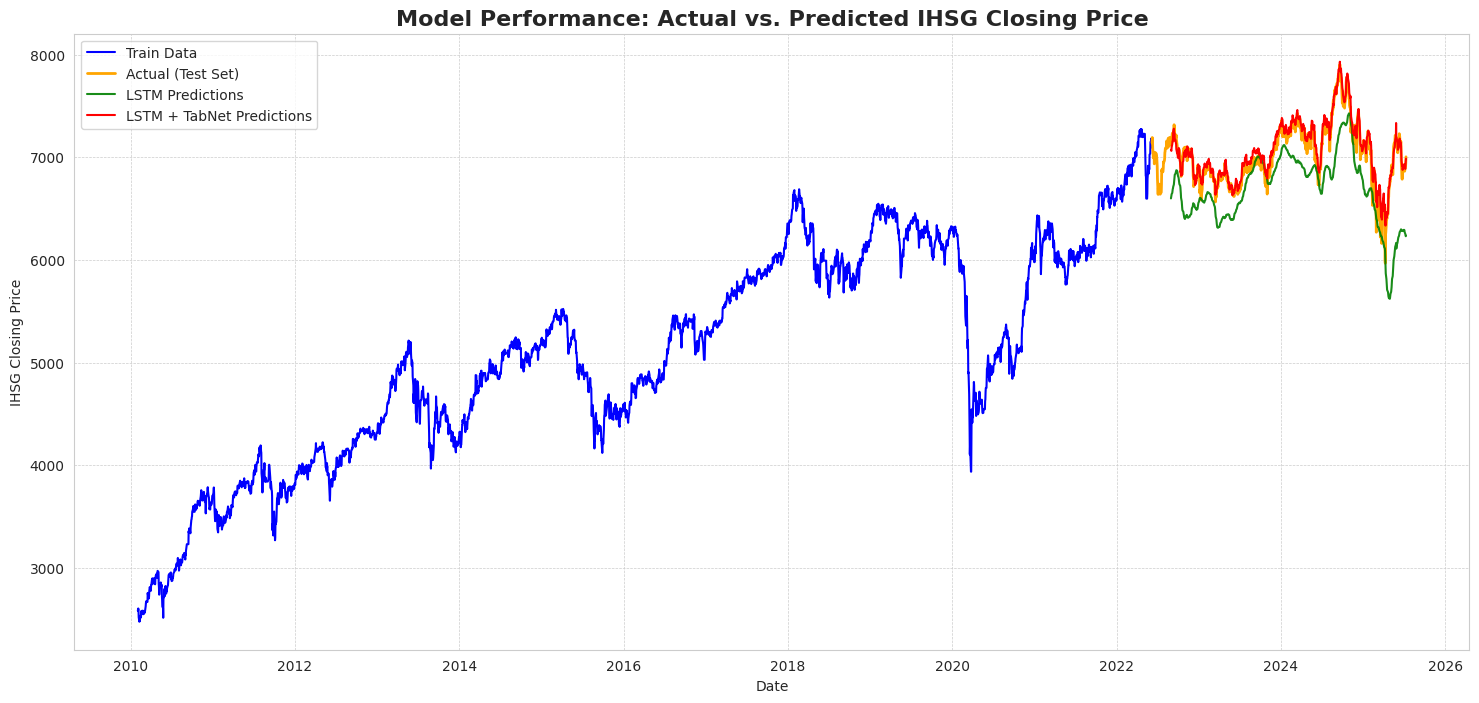

In [17]:
# ------------------------------
# 7. Reconstruct actual prices & Evaluate
# ------------------------------
final_pred = scaler_y.inverse_transform(final_pred_scaled.reshape(-1, 1)).flatten()
lstm_pred = scaler_y.inverse_transform(lstm_pred_test_scaled).flatten()
tabnet_pred = scaler_y.inverse_transform(tabnet_pred_test_scaled).flatten()
y_test_actual = y_test.iloc[TIME_STEPS:].values

def calculate_metrics(y_true, y_pred, model_name="Final Model"):
    metrics = {'Model': model_name, 'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred), 'SMAPE (%)': 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred) + 1e-8))}
    return metrics

metrics_final = calculate_metrics(y_test_actual, final_pred, "Ensemble (LSTM+TabNet)")
metrics_lstm = calculate_metrics(y_test_actual, lstm_pred, "Standalone LSTM")
metrics_tabnet = calculate_metrics(y_test_actual, tabnet_pred, "TabNet")
results_df = pd.DataFrame([metrics_lstm, metrics_tabnet,metrics_final])

print("\n--- Final Combined Model Metrics ---")
print(results_df.to_string())

# --- REVISED PLOTTING LOGIC TO REMOVE GAP ---
train_data = data[:train_size]
valid_data = data[train_size:].copy()
prediction_dates = y_test.index[TIME_STEPS:]
valid_data['Predictions'] = np.nan
valid_data.loc[prediction_dates, 'Predictions'] = final_pred
valid_data['LSTM_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'LSTM_Predictions'] = lstm_pred


# Plotting
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(train_data['IHSG'], label='Train Data', color='blue')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Performing TabNet categorical analysis...

--- Top 15 Overall Feature Importance (TabNet) ---
                            Feature  Importance
98            Copper_pct_change_21d    0.150112
112                       DayOfWeek    0.146389
67              Gold_pct_change_10d    0.107687
26                     MACD_12_26_9    0.098060
111                   Gold_vs_SP500    0.059771
12   Federal Funds Rate (Effective)    0.049231
32                       BBL_20_2.0    0.045748
78                DAX_pct_change_5d    0.035680
8                           S&P 500    0.034923
94             Copper_pct_change_2d    0.033390
2                           EUR/USD    0.031803
7                               DAX    0.022388
41             Nasdaq_pct_change_3d    0.017598
97            Copper_pct_change_10d    0.015776
35            S&P 500_pct_change_3d    0.015764

--- Feature Importance by Category ---
           Category  Total_Importance
2       Commodities          0.408048
1    Global Markets  

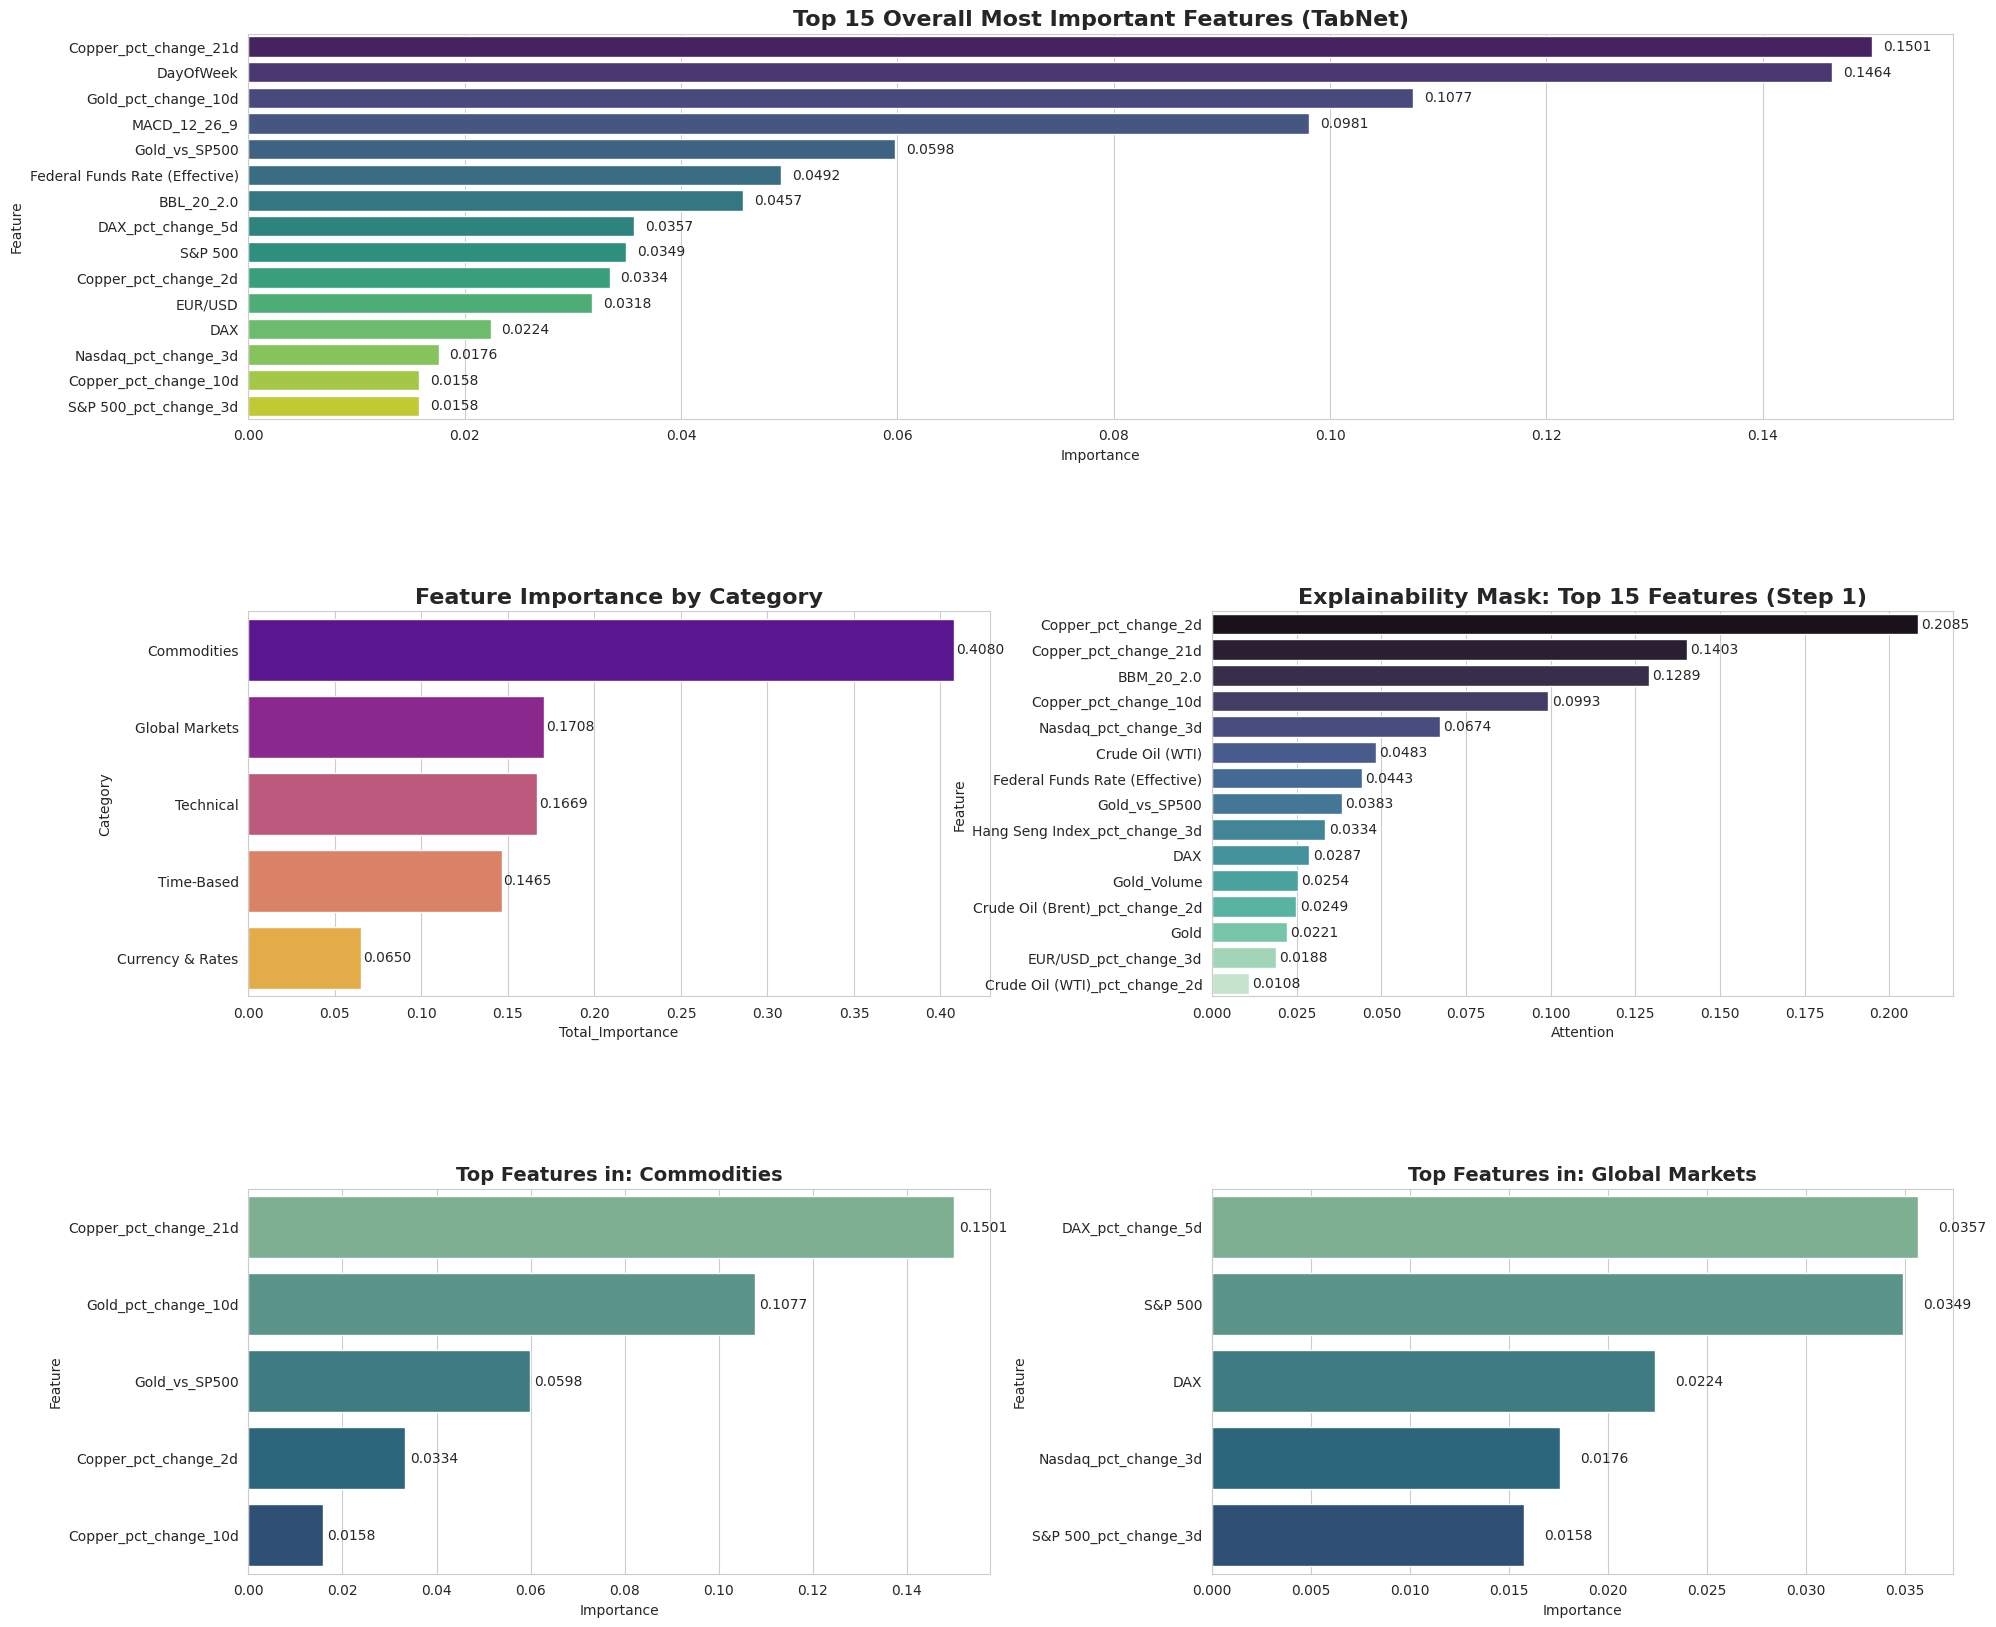

In [18]:
# ===================================================================
# 8. TabNet Feature Importance & Categorical Analysis (RESTORED)
# ===================================================================
print("\nPerforming TabNet categorical analysis...")

importance_df = pd.DataFrame({'Feature': features, 'Importance': final_tabnet.feature_importances_}).sort_values('Importance', ascending=False)

categories_map = {
    'Technical': [c for c in features if any(x in c for x in ['RSI', 'ATR', 'MACD', 'BBL', 'BBM', 'BBU'])],
    'Global Markets': [f for f in features if any(m in f for m in ['S&P 500', 'Nasdaq', 'DAX', 'VIX', 'Hang Seng'])],
    'Commodities': [f for f in features if any(m in f for m in ['Crude Oil', 'Gold', 'Copper', 'Silver'])],
    'Currency & Rates': [f for f in features if any(m in f for m in ['IDR', 'EURUSD', 'Federal Funds Rate'])],
    'Time-Based': ['DayOfWeek', 'Month', 'WeekOfYear']
}

category_importance = {}
for category, cat_features in categories_map.items():
    existing_features = [f for f in cat_features if f in importance_df['Feature'].values]
    category_importance[category] = importance_df[importance_df['Feature'].isin(existing_features)]['Importance'].sum()

category_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance']).sort_values('Total_Importance', ascending=False)

# --- ADDED: Print statements for the data behind the plots ---
print("\n--- Top 15 Overall Feature Importance (TabNet) ---")
print(importance_df.head(15).to_string())
print("\n--- Feature Importance by Category ---")
print(category_df.to_string())


# --- Visualization Dashboard ---
fig = plt.figure(figsize=(22, 20))
gs = fig.add_gridspec(3, 2, hspace=0.5, wspace=0.3)

# Plot 1: Overall Top 15 Features
ax1 = fig.add_subplot(gs[0, :])
top_15_overall = importance_df.head(15)
sns.barplot(data=top_15_overall, x='Importance', y='Feature', ax=ax1, palette='viridis')
ax1.set_title('Top 15 Overall Most Important Features (TabNet)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# Plot 2: Importance by Category
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(data=category_df, x='Total_Importance', y='Category', ax=ax2, palette='plasma')
ax2.set_title('Feature Importance by Category', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# --- UPDATED: Readable Explainability Mask Visualization ---
ax3 = fig.add_subplot(gs[1, 1])
explain_matrix, masks = final_tabnet.explain(X_test_tabular)
# Get the attention scores for the first decision step and average them across all test samples
mask_step1_avg = np.mean(masks[0], axis=0)
mask_df = pd.DataFrame({'Feature': features, 'Attention': mask_step1_avg}).sort_values('Attention', ascending=False)
sns.barplot(data=mask_df.head(15), x='Attention', y='Feature', ax=ax3, palette='mako')
ax3.set_title('Explainability Mask: Top 15 Features (Step 1)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax3.patches:
    width = p.get_width()
    ax3.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')


top_categories = category_df['Category'].head(2).tolist()
axes_cat = [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])]
for i, category in enumerate(top_categories):
    cat_features = categories_map.get(category, [])
    cat_df = importance_df[importance_df['Feature'].isin(cat_features)].head(5)
    ax = axes_cat[i]
    sns.barplot(data=cat_df, x='Importance', y='Feature', ax=ax, palette='crest')
    ax.set_title(f'Top Features in: {category}', fontsize=14, fontweight='bold')
    # Add values to bars
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')


plt.tight_layout()
plt.show()